In [16]:
import os
os.chdir(f"{globals()['_dh'][0]}/..")  # Set cwd up one level

import fastsim
from etron import e_tron
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
sns.set()

In [17]:
cycle = pd.read_csv("data/hwycol.txt", sep="\t")

In [18]:
ev = e_tron()
ev.simulate(cycle)
final_soc = ev.log["SOC"][-1]
print(f"Final SOC: {final_soc * 100}%")
print((ev.log["Battery energy (J)"][0] - ev.log["Battery energy (J)"][-1]) / ev.log["Distance (mi)"][-1] / ev.KWH_TO_J, "kWh/mi")

x = ev.log["Time (s)"]
y1 = ev.log["SOC"] * 100

Final SOC: 97.25713782483719%
0.2541576169477631 kWh/mi


In [19]:
cyc = fastsim.cycle.Cycle(
        cyc_dict={"cycSecs": ev.cycle["Time (s)"], "cycMps": ev.cycle["Velocity (m/s)"]}
    )
veh = fastsim.vehicle.Vehicle(22)

# Vehicle parameter tweaks
veh.vehOverrideKg = 2595
veh.maxEssKwh = 95.0
veh.dragCoef = 0.25
veh.frontalAreaM2 = 2.65
veh.wheelRadiusM = 0.37387784
veh.maxSoc = 1
veh.minSoc = 0.08947368421
veh.set_init_calcs()
veh.set_veh_mass()

sim = fastsim.simdrive.SimDriveClassic(cyc, veh)
sim.sim_drive()
output = fastsim.simdrive.SimDrivePost(sim).get_output()
print(f"Final SOC: {output['soc'][-1] * 100}%")
print((sim.essCurKwh[0] - sim.essCurKwh[-1]) / sum(sim.distMiles), "kWh/mi")

y2 = output['soc'] * 100

Final SOC: 97.50901016143376%
0.23067222376852267 kWh/mi


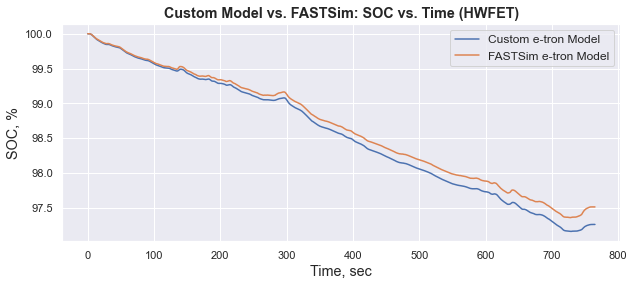

In [20]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.set_title("Custom Model vs. FASTSim: SOC vs. Time (HWFET)", fontsize="large", fontweight="bold")
ax.set_xlabel("Time, sec", fontsize="large")
ax.set_ylabel("SOC, %", fontsize="large")

ax.plot(x, y1, label="Custom e-tron Model")
ax.plot(x, y2, label="FASTSim e-tron Model")
ax.legend(prop={'size': 12})

In [21]:
print(f"Ending SOC Absolute Error: {abs(y2[-1] - y1[-1]) / y1[-1] * 100:.02f}%")
print(f"Mean Absolute Percent Error: {np.mean(abs(y2 - y1) / y1 * 100):.02f}%")
print(f"Mean Absolute Error: {np.mean(abs(y2 - y1)):.03f}")
print(f"Root Mean Squared Error: {mean_squared_error(y1, y2, squared=False):.03f}")

Ending SOC Absolute Error: 0.26%
Mean Absolute Percent Error: 0.10%
Mean Absolute Error: 0.102
Root Mean Squared Error: 0.120


(-0.012664180719016116, 0.35)

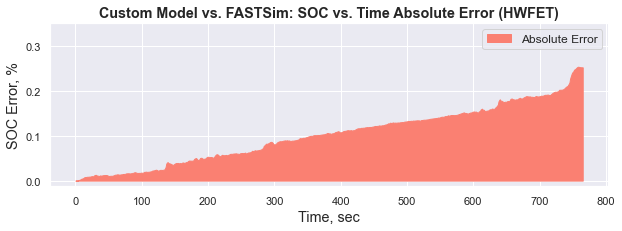

In [26]:
y3 = abs(y1-y2)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)

ax.set_title("Custom Model vs. FASTSim: SOC vs. Time Absolute Error (HWFET)", fontsize="large", fontweight="bold")
ax.set_xlabel("Time, sec", fontsize="large")
ax.set_ylabel("SOC Error, %", fontsize="large")

ax.fill_between(x, y3, np.zeros_like(y3), label="Absolute Error", color="salmon")
ax.legend(prop={'size': 12})

ax.set_ylim(top=0.35)